# Load and Parse Data Files
Import required libraries (pandas, matplotlib, seaborn) and create functions to read and parse bandwidth.log files from both 4-node and 8-node directories

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re


# Function to read and parse bandwidth.log files
def load_bandwidth_data(directory):
    """
    Load and parse bandwidth.log files from the specified directory.
    
    Args:
        directory (str): Path to the directory containing bandwidth.log files.
    
    Returns:
        pd.DataFrame: DataFrame containing parsed data.
    """
    node_count = directory.split('_')[0].replace("./", "").replace("n","")
    print(f"node_count = {node_count}")
    data = []
    
    for test_folder in os.listdir(directory):
        test_folder_path = os.path.join(directory, test_folder)
        
        # Skip if not a directory
        if not os.path.isdir(test_folder_path):
            continue
            
        # print(f"test_folder: {test_folder}")
        
        # Parse test configuration from folder name
        test_config_str = test_folder.split('_')
        if len(test_config_str) < 4:
            print(f"Warning: Unexpected folder name format: {test_folder}")
            continue
            
        tasks_per_node = test_config_str[2]
        ts_size = test_config_str[3].replace("ts","")
        
        # Look for bandwidth.log files in the test folder
        for file in os.listdir(test_folder_path):
            if file.endswith("bandwidth.log"):
                file_path = os.path.join(test_folder_path, file)  # Fixed: use test_folder_path
                
                try:
                    with open(file_path, 'r') as f:
                        content = f.read()
                        match = re.search(r'Copy bandwidth: ([\d.]+) MB/s', content)
                        
                        if match:
                            bandwidth = float(match.group(1))
                            line_data = {
                                "ts_size": ts_size,
                                "tasks_per_node": int(tasks_per_node),
                                "bandwidth": bandwidth,
                                "latency": 0,
                                "node_count": int(node_count)
                            }
                            data.append(line_data)
                            # print(f"line_data : {line_data}")
                        else:
                            print(f"Warning: No bandwidth data found in {file_path}")
                            
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    
    return pd.DataFrame(data)

# Load data from 4-node and 8-node directories
try:
    # data_1n = load_bandwidth_data("./1n_gateway_cp_results_1000bs")
    # data_2n = load_bandwidth_data("./2n_gateway_cp_results_1000bs")
    # data_4n = load_bandwidth_data("./4n_gateway_cp_results_1000bs")
    data_8n = load_bandwidth_data("./8n_gateway_cp_results_1000bs")
    data_10n = load_bandwidth_data("./10n_gateway_cp_results_1000bs")
    data_16n = load_bandwidth_data("./16n_gateway_cp_results_1000bs")
    
    # Combine data for further analysis
    combined_data = pd.concat([data_8n, data_10n], ignore_index=True)
    
    # Display the first few rows of the combined data
    print(combined_data.head())
    
except Exception as e:
    print(f"Error loading data: {e}")

node_count = 8
node_count = 10
  ts_size  tasks_per_node  bandwidth  latency  node_count
0      8k               2     470.58        0           8
1    100m               4     500.00        0           8
2      4k               4     551.72        0           8
3      1m              32     651.39        0           8
4      1m              16     703.29        0           8


# Create Bandwidth Plots
Generate line plots showing bandwidth performance across different tasks per node (1,2,3,8,16,32) for each transfer size in the 4-node setup

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re

def load_bandwidth_data(directory):
    """Enhanced version with better error handling"""
    try:
        node_count = int(directory.split('_')[0].replace("./", "").replace("n",""))
    except (ValueError, IndexError):
        print(f"Warning: Could not parse node count from directory: {directory}")
        node_count = 0
    
    print(f"node_count = {node_count}")
    data = []
    
    if not os.path.exists(directory):
        print(f"Error: Directory {directory} does not exist")
        return pd.DataFrame(data)
    
    for test_folder in os.listdir(directory):
        test_folder_path = os.path.join(directory, test_folder)
        
        if not os.path.isdir(test_folder_path):
            continue
            
        print(f"test_folder: {test_folder}")
        
        # More robust parsing of test configuration
        test_config_parts = test_folder.split('_')
        if len(test_config_parts) < 4:
            print(f"Warning: Unexpected folder name format: {test_folder}")
            continue
        
        try:
            tasks_per_node = int(test_config_parts[2])
            ts_size = test_config_parts[3]
        except (ValueError, IndexError):
            print(f"Warning: Could not parse configuration from: {test_folder}")
            continue
        
        bandwidth_file = os.path.join(test_folder_path, "bandwidth.log")
        if os.path.exists(bandwidth_file):
            try:
                with open(bandwidth_file, 'r') as f:
                    content = f.read()
                    match = re.search(r'Copy bandwidth: ([\d.]+) MB/s', content)
                    
                    if match:
                        bandwidth = float(match.group(1))
                        line_data = {
                            "ts_size": ts_size,
                            "tasks_per_node": tasks_per_node,
                            "bandwidth": bandwidth,
                            "latency": 0,
                            "node_count": node_count
                        }
                        data.append(line_data)
                        print(f"line_data : {line_data}")
                    else:
                        print(f"Warning: No bandwidth data found in {bandwidth_file}")
                        
            except Exception as e:
                print(f"Error reading {bandwidth_file}: {e}")
        else:
            print(f"Warning: bandwidth.log not found in {test_folder_path}")
                    
    return pd.DataFrame(data)

def plot_bandwidth_data(data):
    """
    Plot bandwidth data for any node count
    x-axis: ts_size, y-axis: bandwidth (MB/s)
    Different colors for different tasks_per_node values
    
    Parameters:
    data (pd.DataFrame): DataFrame containing bandwidth data with columns:
                        'ts_size', 'tasks_per_node', 'bandwidth', 'node_count'
    """
    
    if data.empty:
        print("Warning: No data to plot")
        return
    
    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Get unique tasks_per_node values
    all_tasks = sorted(data['tasks_per_node'].unique())
    
    # Create color map
    colors = plt.cm.Set1(np.linspace(0, 1, len(all_tasks)))
    color_map = {task: color for task, color in zip(all_tasks, colors)}
    
    # Helper function to convert ts_size to numeric for proper ordering
    def ts_size_to_numeric(ts_size):
        """Convert ts_size string to numeric value for plotting"""
        if isinstance(ts_size, str):
            # Remove any non-numeric characters except 'k', 'M', 'G'
            ts_clean = ts_size.upper().replace('B', '').replace('BYTE', '')
            
            if 'K' in ts_clean:
                return float(ts_clean.replace('K', '')) * 1024
            elif 'M' in ts_clean:
                return float(ts_clean.replace('M', '')) * 1024 * 1024
            elif 'G' in ts_clean:
                return float(ts_clean.replace('G', '')) * 1024 * 1024 * 1024
            else:
                try:
                    return float(ts_clean)
                except:
                    return 0
        return ts_size
    
    # Prepare data for plotting
    data_plot = data.copy()
    data_plot['ts_size_numeric'] = data_plot['ts_size'].apply(ts_size_to_numeric)
    data_plot = data_plot.sort_values('ts_size_numeric')
    
    # Plot data for each tasks_per_node
    for task in all_tasks:
        subset = data_plot[data_plot['tasks_per_node'] == task]
        ax.scatter(subset['ts_size'], subset['bandwidth'], 
                  color=color_map[task], label=f'{task} tasks/node', 
                  s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Get node count for title
    node_count = data['node_count'].iloc[0] if 'node_count' in data.columns else 'Unknown'
    
    ax.set_title(f'{node_count} Nodes Bandwidth Performance', fontsize=14, fontweight='bold')
    ax.set_xlabel('Transfer Size (ts_size)', fontsize=12)
    ax.set_ylabel('Bandwidth (MB/s)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(title='Tasks per Node', loc='best')
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

def plot_combined_bandwidth_data(data_4n, data_8n):
    """
    Plot both 4 nodes and 8 nodes data on the same plot
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Get unique tasks_per_node values from both datasets
    all_tasks = set()
    if not data_4n.empty:
        all_tasks.update(data_4n['tasks_per_node'].unique())
    if not data_8n.empty:
        all_tasks.update(data_8n['tasks_per_node'].unique())
    
    # Create color map
    colors = plt.cm.Set1(np.linspace(0, 1, len(all_tasks)))
    color_map = {task: color for task, color in zip(sorted(all_tasks), colors)}
    
    # Helper function to convert ts_size to numeric for proper ordering
    def ts_size_to_numeric(ts_size):
        if isinstance(ts_size, str):
            ts_clean = ts_size.upper().replace('B', '').replace('BYTE', '')
            
            if 'K' in ts_clean:
                return float(ts_clean.replace('K', '')) * 1024
            elif 'M' in ts_clean:
                return float(ts_clean.replace('M', '')) * 1024 * 1024
            elif 'G' in ts_clean:
                return float(ts_clean.replace('G', '')) * 1024 * 1024 * 1024
            else:
                try:
                    return float(ts_clean)
                except:
                    return 0
        return ts_size
    
    # Plot 4 nodes data
    if not data_4n.empty:
        data_4n_plot = data_4n.copy()
        data_4n_plot['ts_size_numeric'] = data_4n_plot['ts_size'].apply(ts_size_to_numeric)
        data_4n_plot = data_4n_plot.sort_values('ts_size_numeric')
        
        for task in sorted(data_4n_plot['tasks_per_node'].unique()):
            subset = data_4n_plot[data_4n_plot['tasks_per_node'] == task]
            ax.scatter(subset['ts_size'], subset['bandwidth'], 
                      color=color_map[task], label=f'4 nodes, {task} tasks/node', 
                      s=80, alpha=0.7, edgecolors='black', linewidth=0.5, 
                      marker='o')
    
    # Plot 8 nodes data
    if not data_8n.empty:
        data_8n_plot = data_8n.copy()
        data_8n_plot['ts_size_numeric'] = data_8n_plot['ts_size'].apply(ts_size_to_numeric)
        data_8n_plot = data_8n_plot.sort_values('ts_size_numeric')
        
        for task in sorted(data_8n_plot['tasks_per_node'].unique()):
            subset = data_8n_plot[data_8n_plot['tasks_per_node'] == task]
            ax.scatter(subset['ts_size'], subset['bandwidth'], 
                      color=color_map[task], label=f'8 nodes, {task} tasks/node', 
                      s=80, alpha=0.7, edgecolors='black', linewidth=0.5, 
                      marker='s')  # Different marker for 8 nodes
    
    ax.set_title('Bandwidth Performance Comparison: 4 vs 8 Nodes', fontsize=14, fontweight='bold')
    ax.set_xlabel('Transfer Size (ts_size)', fontsize=12)
    ax.set_ylabel('Bandwidth (MB/s)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(title='Configuration', loc='best')
    
    plt.tight_layout()
    plt.show()


# # Plot data individually - you can choose which one to plot
# plot_bandwidth_data(data_4n)  # Plot only 4 nodes data
plot_bandwidth_data(data_8n)  # Plot only 8 nodes data
plot_bandwidth_data(data_10n)  # Plot only 8 nodes data
plot_bandwidth_data(data_16n)  # Plot only 8 nodes data


NameError: name 'data_8n' is not defined

In [ ]:
def convert_to_dataframe_and_save_csv(data_dict, filename="bandwidth_performance_data.csv"):
    """
    Convert bandwidth performance data dictionary to DataFrame and save to CSV
    
    Parameters:
    data_dict (dict): Dictionary with keys as node configurations and values as DataFrames
                     Example: {"4n": data_4n, "8n": data_8n}
    filename (str): Output CSV filename
    
    Returns:
    pd.DataFrame: Combined DataFrame with all data
    """
    
    combined_data = []
    
    for node_config, df in data_dict.items():
        if df.empty:
            print(f"Warning: No data found for {node_config}")
            continue
            
        # Convert to DataFrame if it's not already (just in case)
        if not isinstance(df, pd.DataFrame):
            df = pd.DataFrame(df)
            
        # Add node configuration column
        df_copy = df.copy()
        df_copy['node_config'] = node_config
        
        # Reorder columns to put node_config first
        columns = ['node_config'] + [col for col in df_copy.columns if col != 'node_config']
        df_copy = df_copy[columns]
        
        combined_data.append(df_copy)
        print(f"Added {len(df_copy)} rows for {node_config}")
    
    if not combined_data:
        print("Error: No data to save")
        return pd.DataFrame()
    
    # Combine all data into a single DataFrame
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # Sort by node_config, then by tasks_per_node, then by ts_size
    def ts_size_to_numeric_sort(ts_size):
        """Convert ts_size string to numeric value for sorting"""
        if isinstance(ts_size, str):
            ts_clean = ts_size.upper().replace('B', '').replace('BYTE', '')
            
            if 'K' in ts_clean:
                return float(ts_clean.replace('K', '')) * 1024
            elif 'M' in ts_clean:
                return float(ts_clean.replace('M', '')) * 1024 * 1024
            elif 'G' in ts_clean:
                return float(ts_clean.replace('G', '')) * 1024 * 1024 * 1024
            else:
                try:
                    return float(ts_clean)
                except:
                    return 0
        return ts_size
    
    # Add numeric ts_size for sorting
    combined_df['ts_size_numeric'] = combined_df['ts_size'].apply(ts_size_to_numeric_sort)
    combined_df = combined_df.sort_values(['node_config', 'tasks_per_node', 'ts_size_numeric'])
    
    # Remove the temporary numeric column
    combined_df = combined_df.drop('ts_size_numeric', axis=1)
    
    # Save DataFrame to CSV
    combined_df.to_csv(filename, index=False)
    
    print(f"\nDataFrame created and saved to {filename}")
    print(f"DataFrame shape: {combined_df.shape}")
    print(f"Columns: {list(combined_df.columns)}")
    print(f"Node configurations: {combined_df['node_config'].unique()}")
    print(f"Tasks per node values: {sorted(combined_df['tasks_per_node'].unique())}")
    
    # Display first few rows
    print(f"\nFirst 5 rows of combined DataFrame:")
    print(combined_df.head())
    
    return combined_df

def load_bandwidth_data_from_csv(filename="bandwidth_performance_data.csv"):
    """
    Load bandwidth performance data from CSV file
    
    Parameters:
    filename (str): CSV filename to load
    
    Returns:
    dict: Dictionary with node configurations as keys and DataFrames as values
    """
    
    try:
        df = pd.read_csv(filename)
        print(f"Loaded data from {filename}")
        print(f"Total rows: {len(df)}")
        print(f"Columns: {list(df.columns)}")
        
        # Split data by node configuration
        data_dict = {}
        for node_config in df['node_config'].unique():
            subset = df[df['node_config'] == node_config].copy()
            # Remove node_config column from individual DataFrames
            subset = subset.drop('node_config', axis=1)
            data_dict[node_config] = subset
            print(f"{node_config}: {len(subset)} rows")
        
        return data_dict
        
    except FileNotFoundError:
        print(f"Error: File {filename} not found")
        return {}
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return {}
    
# Convert to DataFrame and save to CSV
data_dict = {"8n": data_8n, "10n": data_10n}
combined_df = convert_to_dataframe_and_save_csv(data_dict, "bandwidth_performance_data.csv")

# Now you have a combined DataFrame that you can use for further analysis
print(combined_df.head())

Added 78 rows for 8n
Added 18 rows for 10n

DataFrame created and saved to bandwidth_performance_data.csv
DataFrame shape: (96, 6)
Columns: ['node_config', 'ts_size', 'tasks_per_node', 'bandwidth', 'latency', 'node_count']
Node configurations: ['10n' '8n']
Tasks per node values: [1, 2, 4, 8, 16, 32]

First 5 rows of combined DataFrame:
   node_config ts_size  tasks_per_node  bandwidth  latency  node_count
84         10n      1m               1     666.66        0          10
87         10n      1m               1     714.28        0          10
95         10n      1m               1     666.66        0          10
90         10n      1m               2     833.33        0          10
92         10n      1m               2     833.33        0          10
   node_config ts_size  tasks_per_node  bandwidth  latency  node_count
84         10n      1m               1     666.66        0          10
87         10n      1m               1     714.28        0          10
95         10n      1m 

Summary table:
   tasks_per_node     mean_bw     std_bw  count  std_error
0               1  448.631333  20.133474     15   5.198441
1               2  477.393333  11.392684     15   2.941578
2               4  477.524000  22.303632     15   5.758773
3               8  622.176000  22.942666     15   5.923771
4              16  705.341333  23.778183     15   6.139500
5              32  688.040000  33.499673      3  19.341045


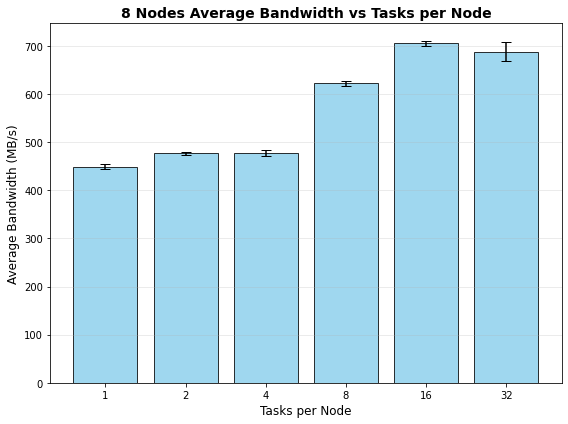

Summary table:
   tasks_per_node     mean_bw     std_bw  count  std_error
0               1  682.533333  27.493420      3  15.873333
1               2  833.330000   0.000000      3   0.000000
2               4  937.950000  24.993493      3  14.430000
3               8  975.700000  11.900315      3   6.870650
4              16  958.990000  36.462448      3  21.051604
5              32  916.813333  33.285006      3  19.217107


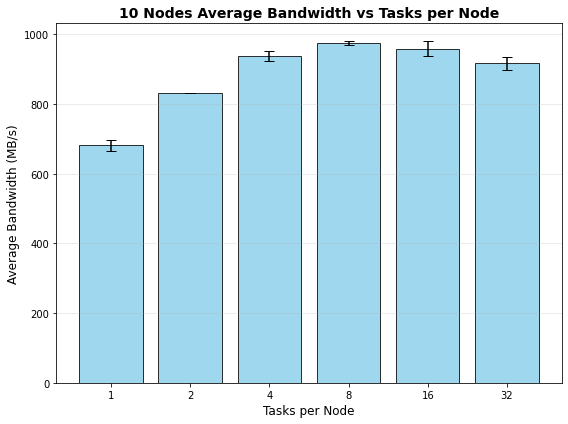

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bandwidth_by_tasks(data, nodes=1):
    """
    Plot a bar plot showing average bandwidth (MB/s) vs tasks_per_node,
    with standard error bars.
    
    Parameters:
    data (pd.DataFrame): DataFrame with columns: 
                         'tasks_per_node', 'bandwidth', ...
    """
    if data.empty:
        print("Warning: No data to plot")
        return
    
    # Group by tasks_per_node, calculate mean and standard error
    summary = data.groupby('tasks_per_node').agg(
        mean_bw=('bandwidth', 'mean'),
        std_bw=('bandwidth', 'std'),
        count=('bandwidth', 'count')
    ).reset_index()
    
    # Calculate standard error
    summary['std_error'] = summary['std_bw'] / np.sqrt(summary['count'])
    
    print("Summary table:")
    print(summary)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.bar(
        summary['tasks_per_node'].astype(str),
        summary['mean_bw'],
        yerr=summary['std_error'],
        capsize=5,
        color='skyblue',
        edgecolor='black',
        alpha=0.8
    )
    
    ax.set_xlabel('Tasks per Node', fontsize=12)
    ax.set_ylabel('Average Bandwidth (MB/s)', fontsize=12)
    ax.set_title(f'{nodes} Nodes Average Bandwidth vs Tasks per Node', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# plot_bandwidth_by_tasks(data_1n, nodes=1)
# plot_bandwidth_by_tasks(data_2n, nodes=2)
# plot_bandwidth_by_tasks(data_4n, nodes=4)
plot_bandwidth_by_tasks(data_8n, nodes=8)
plot_bandwidth_by_tasks(data_10n, nodes=10)
plot_bandwidth_by_tasks(data_16n, nodes=16)

In [ ]:
import csv

def find_best_bandwidth_config(data, output_csv):
    """
    Find the single best bandwidth config from the DataFrame.
    Input:
        data: pd.DataFrame with at least columns ['tasks_per_node', 'bandwidth']
    """
    if data.empty:
        print("Warning: Input data is empty")
        return

    # Find row with max bandwidth
    best_row = data.loc[data['bandwidth'].idxmax()]

    tasks_per_node = best_row['tasks_per_node']
    best_bandwidth = best_row['bandwidth']

    # Save to CSV
    with open(output_csv, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['TasksPerNode', 'BestBandwidth(MiB/s)'])
        writer.writerow([
            tasks_per_node,
            f"{best_bandwidth:.2f}"
        ])

    print("Best bandwidth configuration:")
    print(f"Tasks per Node: {tasks_per_node}")
    print(f"Best Bandwidth (MiB/s): {best_bandwidth:.2f}")
    print(f"Saved to {output_csv}")
    print("-----------------------------")


# find_best_bandwidth_config(data_1n, 'best_bandwidth_1gb_pertask_1n_cp.csv')
# find_best_bandwidth_config(data_2n, 'best_bandwidth_1gb_pertask_2n_cp.csv')
# find_best_bandwidth_config(data_4n, 'best_bandwidth_1gb_pertask_4n_cp.csv')
find_best_bandwidth_config(data_8n, 'best_bandwidth_1gb_pertask_8n_cp.csv')
find_best_bandwidth_config(data_10n, 'best_bandwidth_1gb_pertask_10n_cp.csv')
find_best_bandwidth_config(data_16n, 'best_bandwidth_1gb_pertask_16n_cp.csv')

Best bandwidth configuration:
Tasks per Node: 16
Best Bandwidth (MiB/s): 739.88
Saved to best_bandwidth_1gb_pertask_8n_cp.csv
-----------------------------
Best bandwidth configuration:
Tasks per Node: 16
Best Bandwidth (MiB/s): 1000.00
Saved to best_bandwidth_1gb_pertask_10n_cp.csv
-----------------------------
